<a href="https://colab.research.google.com/github/GStravinsky/Music-diversity-measures/blob/master/Entropy_subsample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [154]:
import numpy as np
import pandas as pd 
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import math
from scipy.stats import pearsonr
from sklearn.metrics import r2_score
from scipy.stats import entropy
from tqdm import tqdm

In [129]:
! pip install tqdm

In [43]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Loading all data

Loading all datasets used - main triplet data, embedded vectors generates with Poisson factotization, bridge data that connects TrackId with SongId and song genre data. 

In [137]:
# main triplet data
data = pd.read_csv("/content/drive/My Drive/MSc Statistics/train_triplets.txt",
                   delimiter="\t", header=None, names= ["UserId", "SongId", "Count"])

In [138]:
print(len(data["UserId"].unique().tolist()), len(data["SongId"].unique().tolist()))

1019318 384546


In [183]:
data.shape

(48373586, 3)

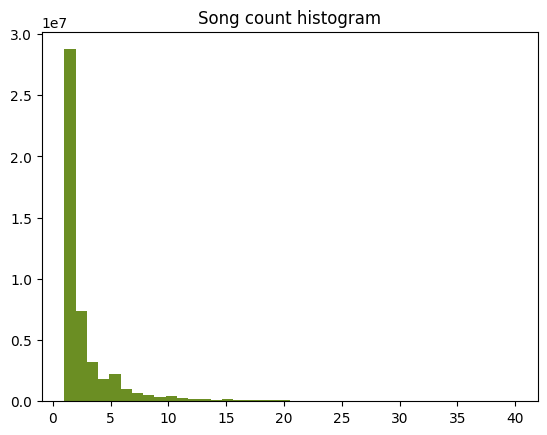

In [179]:
plt.hist(data["Count"][data["Count"]<=40], bins = 40, color = "olivedrab")
plt.title("Song count histogram")
plt.savefig("count_hist", format = "png", transparent = True)

In [184]:
data.describe()

,Count
count,4.837359e+07
mean,2.866859e+00
std,6.437725e+00
min,1.000000e+00
25%,1.000000e+00
50%,1.000000e+00
75%,3.000000e+00
max,9.667000e+03


In [45]:
# data to connect TrackId with SongId
bridge = pd.read_csv("/content/drive/My Drive/MSc Statistics/unique_tracks.txt",  delimiter="<SEP>", header=None, 
                    names= ["TrackId", "SongId", "Artist", "Song_name"])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
bridge.head()

,TrackId,SongId,Artist,Song_name
0,TRMMMYQ128F932D901,SOQMMHC12AB0180CB8,Faster Pussy cat,Silent Night
1,TRMMMKD128F425225D,SOVFVAK12A8C1350D9,Karkkiautomaatti,Tanssi vaan
2,TRMMMRX128F93187D9,SOGTUKN12AB017F4F1,Hudson Mohawke,No One Could Ever
3,TRMMMCH128F425532C,SOBNYVR12A8C13558C,Yerba Brava,Si Vos Querés
4,TRMMMWA128F426B589,SOHSBXH12A8C13B0DF,Der Mystic,Tangle Of Aspens


In [ ]:
print(len(bridge["Artist"].unique().tolist()))

(1000000, 4)

In [ ]:
# song genre data
genres = pd.read_csv("/content/drive/My Drive/MSc Statistics/ganres.txt",  delimiter="\t", header=None,
                     names= ["TrackId", "Main_genre", "Minor_genre"])

In [ ]:
genres.head()

,TrackId,Main_genre,Minor_genre
0,TRAAAAK128F9318786,Rock,NaN
1,TRAAAAW128F429D538,Rap,NaN
2,TRAAABD128F429CF47,Rock,RnB
3,TRAAADJ128F4287B47,Rock,NaN
4,TRAAADZ128F9348C2E,Latin,NaN


In [ ]:
genres.shape

(280831, 3)

# Merging the data

Merging the data so we could connect SongId with some metadata. Conducting the same data analysis below.

In [46]:
artist_merge = pd.merge(left = data, right = bridge, left_on="SongId", right_on="SongId")

In [ ]:
artist_merge.head()

,UserId,SongId,Count,TrackId,Artist,Song_name
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1,TRIQAUQ128F42435AD,Jack Johnson,The Cove
1,7c86176941718984fed11b7c0674ff04c029b480,SOAKIMP12A8C130995,1,TRIQAUQ128F42435AD,Jack Johnson,The Cove
2,76235885b32c4e8c82760c340dc54f9b608d7d7e,SOAKIMP12A8C130995,3,TRIQAUQ128F42435AD,Jack Johnson,The Cove
3,250c0fa2a77bc6695046e7c47882ecd85c42d748,SOAKIMP12A8C130995,1,TRIQAUQ128F42435AD,Jack Johnson,The Cove
4,3f73f44560e822344b0fb7c6b463869743eb9860,SOAKIMP12A8C130995,6,TRIQAUQ128F42435AD,Jack Johnson,The Cove


In [ ]:
print(artist_merge.shape)

(49664528, 6)


In [ ]:
print(len(artist_merge["UserId"].unique().tolist()))

1019318


In [ ]:
ganre_merge = pd.merge(left = mid_merge, right = data, left_on="SongId", right_on="SongId")

In [ ]:
ganre_merge.head()

,TrackId,Main_genre,Minor_genre,SongId,Artist,Song_name,UserId,Count
0,TRAAAAK128F9318786,Rock,NaN,SOBLFFE12AF72AA5BA,Adelitas Way,Scream,cf9a8225b3626e668facf9dda53a2ef3da445bf6,1
1,TRAAAAK128F9318786,Rock,NaN,SOBLFFE12AF72AA5BA,Adelitas Way,Scream,6776279a369a04148a92597d270ac500ddc7a27c,3
2,TRAAAAK128F9318786,Rock,NaN,SOBLFFE12AF72AA5BA,Adelitas Way,Scream,8c412b22910a9c9531ac72ec742913d73317782d,1
3,TRAAAAK128F9318786,Rock,NaN,SOBLFFE12AF72AA5BA,Adelitas Way,Scream,74230c5555c9f4e929f8e6c25344b7ee1f37d9e3,2
4,TRAAAAK128F9318786,Rock,NaN,SOBLFFE12AF72AA5BA,Adelitas Way,Scream,dac762704dfe74075187e98623f92268727bf749,1


# Subsampling triplets

Creating a 100 user subsample of dataset for quick concept checking.

In [65]:
toy_triplets = pd.DataFrame(artist_merge['UserId'].unique(), columns=["UserId"]).sample(n=10000, random_state=123)

In [ ]:
toy_triplets

,UserId
892790,6922083dbcd4cdb8d1d85c3d63fcedeafc9bddc2
962264,9a4a0fd94d767a8f96aaaa5332ff441b3f060cd5
948679,21c310f8a98769736f6e82d6f2cd6fd83d88391d
243789,e13b56d6997fcafa2967a79f9709bd75c2307172
681051,5540dd4a1b6ec2642ee4c586b3c35d4c73cdcb6c
...,...
718997,79f2eb11dc65441d2022349a1ed4c08d46a7cbaf
965441,0b284c5b4c80ddac153a9fc2625f0bd8a4090c13
816419,4351a0fb1fe6ddf233b7b5b712965666c32261a1
386864,e2d5ad3da6ebec21c911d0c2cf1cb76531faf8f2


In [48]:
len(toy_triplets["UserId"].unique().tolist())

10000

In [66]:
toy_triplets = pd.merge(left = toy_triplets, right = artist_merge, left_on="UserId", right_on="UserId")

In [ ]:
toy_triplets.head()

,UserId,SongId,Count,TrackId,Artist,Song_name
0,6922083dbcd4cdb8d1d85c3d63fcedeafc9bddc2,SOBCOYF12A58A7B527,2,TRNXYOV128F42A04FA,Joshua Radin,Only You
1,6922083dbcd4cdb8d1d85c3d63fcedeafc9bddc2,SOHKQAW12A6D4F93D0,2,TREPXQV128F14840BF,Ryan Adams,Gonna Make You Love Me
2,6922083dbcd4cdb8d1d85c3d63fcedeafc9bddc2,SOUBNHU12A8C142E65,2,TRKEIZP12903D05324,Joshua Radin,Sky
3,6922083dbcd4cdb8d1d85c3d63fcedeafc9bddc2,SOMKLPM12AF72A8B36,2,TRVPRMC128F42AE854,Ryan Adams,English Girls Approximately
4,6922083dbcd4cdb8d1d85c3d63fcedeafc9bddc2,SOQZFAC12A8C141E9A,2,TRXLPRQ12903D05327,Joshua Radin,They Bring Me To You


In [67]:
print("Number of unique users:", len(toy_triplets["UserId"].unique().tolist()), ",",
"Number of unique songs:", len(toy_triplets["SongId"].unique().tolist()))

Number of unique users: 10000 , Number of unique songs: 105296


In [ ]:
#toy_artist_merge = pd.merge(left = toy_triplets, right = bridge, left_on="SongId", right_on="SongId")

count    484499.000000
mean          2.885445
std           6.519508
min           1.000000
25%           1.000000
50%           1.000000
75%           3.000000
max        1222.000000
Name: Count, dtype: float64

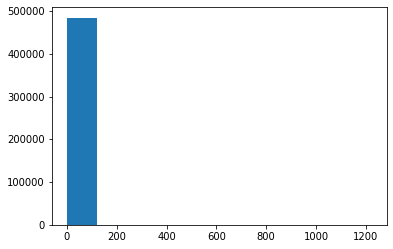

In [109]:
plt.hist(toy_triplets["Count"])
toy_triplets["Count"].describe()

In [110]:
sum_art = toy_triplets.groupby(["Artist"]).size()

In [111]:
sum_art

Artist
!!!                     25
& And Oceans             2
'68 Comeback             2
'N Sync/Phil Collins    13
'Til Tuesday             6
                        ..
Íon                      2
Ólafur Arnalds          32
Órla Fallon              1
Özlem Tekin              1
üNN                      1
Length: 21365, dtype: int64

#Entropy implementation

## Shannon Entropy


In [68]:
def entropy_me(p):
    c = []
    for i in p:
        if i == 0:
            b = 0
        else:
            b = -i*math.log2(i)
        c.append(b)
    d = sum(c)
    return d

In [69]:
# getting a list of unique UserIds
users = toy_triplets["UserId"].unique().tolist()

# calculating the Shannon entropy for each user separatelly and stacking
# everything into the list "shannon"
shannon = []
for i in users:
  b = toy_triplets["Count"][toy_triplets["UserId"]==i]/(np.sum(toy_triplets["Count"][toy_triplets["UserId"]==i]))
  #a = entropy_me(b)
  a = entropy(b, base = 2)
  shannon.append(a)

In [71]:
#np.save("shannon", shannon)

In [73]:
len(shannon)

10000

(array([  1.,   2.,   1.,   3.,   3.,  11.,  25.,  32.,  56., 129., 229.,
        368., 679., 771., 761., 741., 695., 690., 598., 534., 478., 503.,
        437., 412., 363., 338., 235., 207., 141., 143., 103.,  82.,  70.,
         46.,  42.,  26.,  22.,  10.,   8.,   5.]),
 array([0.60899634, 0.81916881, 1.02934128, 1.23951375, 1.44968622,
        1.6598587 , 1.87003117, 2.08020364, 2.29037611, 2.50054858,
        2.71072105, 2.92089352, 3.13106599, 3.34123846, 3.55141093,
        3.7615834 , 3.97175587, 4.18192834, 4.39210081, 4.60227328,
        4.81244575, 5.02261822, 5.23279069, 5.44296316, 5.65313563,
        5.8633081 , 6.07348057, 6.28365304, 6.49382551, 6.70399798,
        6.91417045, 7.12434292, 7.3345154 , 7.54468787, 7.75486034,
        7.96503281, 8.17520528, 8.38537775, 8.59555022, 8.80572269,
        9.01589516]),
 <a list of 40 Patch objects>)

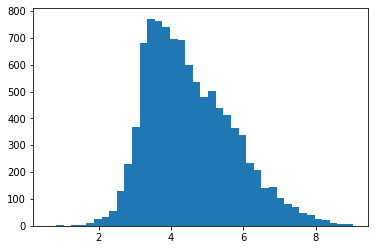

In [72]:
# histograms
plt.hist(shannon, bins=40)

Interesting bell-shapped distribution with right skew around the median. Overall, a nice spread of entropies - might indicate that it manages to separate even close cases.

### Further vizualisations



We will examine the relationship between the Shannon entropy score and total playcount, coverage (number of distinct songs, artist) and popularity.

In [74]:
# total playcount
total_playcount = []
for i in users:
  total_playcount.append(np.sum(toy_triplets["Count"][toy_triplets["UserId"]==i]))
# np.save("total_playcount", total_playcount)

In [ ]:
plt.hist(total_playcount, bins = 40)

(0.5300136858245862, 0.0)


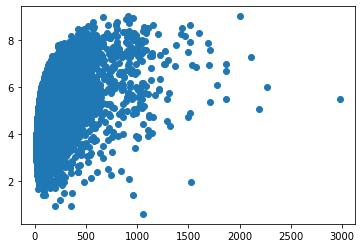

In [77]:
plt.scatter(total_playcount, shannon)
print(pearsonr(total_playcount, shannon))

In [78]:
# song coverage
distinct_songs = []
for i in users:
  distinct_songs.append(np.sum(toy_triplets["UserId"]==i))
#np.save("distinct_songs", distinct_songs)

(0.8191249846228508, 0.0)


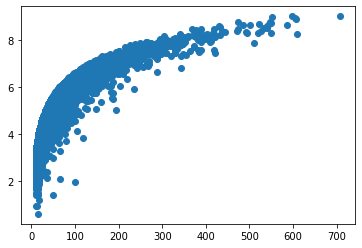

In [80]:
plt.scatter(distinct_songs, shannon)
print(pearsonr(distinct_songs, shannon))

In [81]:
# artist coverage
distinct_artists = []
for i in users:
  a = len(toy_triplets["Artist"][toy_triplets["UserId"]==i].unique().tolist())
  distinct_artists.append(a)
#np.save("distinct_artists", distinct_artists) 

(0.7682570978030047, 0.0)


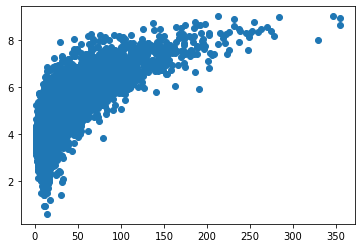

In [82]:
plt.scatter(distinct_artists, shannon)
print(pearsonr(distinct_artists, shannon))

In [ ]:
# popularity measure - refer to notes.
# Consructing a synthetic user who listens only to the song which at least 10%
# of the population listened to at least once


# getting Q - a user who listens only to popular songs

# getting a list of unique SongId

# define q^1 - each instance of song being played at least onces corresponds to
# a one count in q^1
sum_song = toy_triplets.groupby(["SongId"]).size()
sum_song = sum_song.to_frame()
sum_song["SongId"] = sum_song.index
sum_song.columns = ["Count_q", "SongId"]

In [105]:
# Now we want to retain songs that are listened by the 10% of the population
Q_max = sum_song[sum_song["Count_q"]>500]

In [124]:
Q_max = sum_song.sort_values(by = "Count_q", ascending=False)[:500]

In [126]:
Q_max

,Count_q,SongId
SongId,,
SOFRQTD12A81C233C0,1045,SOFRQTD12A81C233C0
SOWCKVR12A8C142411,960,SOWCKVR12A8C142411
SOAUWYT12A81C206F1,872,SOAUWYT12A81C206F1
SOAXGDH12A8C13F8A1,832,SOAXGDH12A8C13F8A1
SOBONKR12A58A7A7E0,789,SOBONKR12A58A7A7E0
...,...,...
SONVPTP12A6D4F7A34,68,SONVPTP12A6D4F7A34
SOSELMV12A6D4FCF5A,68,SOSELMV12A6D4FCF5A
SOXCEYU12A6D4F3E70,68,SOXCEYU12A6D4F3E70


In [125]:
Q_max.describe()

,Count_q
count,500.000000
mean,158.744000
std,136.210297
min,68.000000
25%,81.000000
50%,107.000000
75%,178.000000
max,1045.000000


In [133]:
pop_score = []
for i in tqdm(users):
  b = []
  a = toy_triplets["SongId"][toy_triplets["UserId"]==i].values
  for j in Q_max["SongId"]:
    if j in a:
      b.append(1)
    else:
      b.append(0)
  pop_score.append(np.sum(b))   

100%|██████████| 10000/10000 [05:53<00:00, 28.29it/s]


In [135]:
np.save("pop_score", pop_score)

(0.43138836357600985, 0.0)


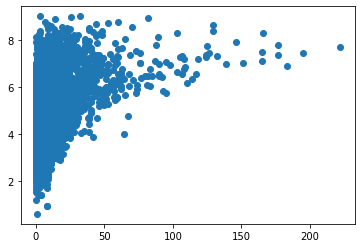

In [136]:
plt.scatter(pop_score, shannon)
print(pearsonr(pop_score, shannon))

## Kulback-Leibler divergence

In [ ]:
# Kullback-Leibner divergence function
def KL(p,q):
    c = []
    for i, j in zip(p,q):
        if i == 0:
            b = 0
        else:
            b = -i*math.log2(i/j)
        c.append(b)
    d = sum(c)
    return d

In [ ]:
# getting Q - theoretical distribution

# getting a list of unique SongId
songs = toy_triplets["SongId"].unique().tolist()

# define q^1 - each instance of song being played at least onces corresponds to
# a one count in q^1
#Q = []
#for i in songs:
  # a = np.sum(toy_triplets["SongId"]==i)
  # Q.append(a)

# shaping into probabilities
Q_p = Q/sum(Q)

# placing into pandas
Q_joint = {"SongId": songs, "Freq_q": Q_p}
Q_joint = pd.DataFrame(Q_joint, columns = ["SongId", "Freq_q"])

In [ ]:
# list users from above (Shannon entropy)
relative = []
for u in users:
  # subset the Count and SongID data for each user
  p = toy_triplets[toy_triplets["UserId"] == u]
  # merge with Q so that the absent songs would disappear (p_ij = 0 contributes
  # 0 to KL, hence it is equivalent to discard it a priori)
  mid = pd.merge(left = p, right = Q_joint, left_on = "SongId", 
                 right_on = "SongId")
  # defining a p_ij variable as a percentage 
  a = mid["Count"]/np.sum(mid["Count"])
  # KL function aggregate
  relative.append(KL(a, mid["Freq_q"]))

(array([1., 0., 0., 0., 0., 4., 1., 1., 0., 0., 1., 3., 2., 1., 6., 2., 5.,
        4., 3., 6., 6., 4., 7., 2., 9., 2., 5., 2., 3., 3., 4., 4., 1., 3.,
        2., 0., 0., 1., 0., 2.]),
 array([-11.24423712, -11.05336221, -10.8624873 , -10.67161239,
        -10.48073748, -10.28986257, -10.09898766,  -9.90811275,
         -9.71723783,  -9.52636292,  -9.33548801,  -9.1446131 ,
         -8.95373819,  -8.76286328,  -8.57198837,  -8.38111346,
         -8.19023855,  -7.99936364,  -7.80848872,  -7.61761381,
         -7.4267389 ,  -7.23586399,  -7.04498908,  -6.85411417,
         -6.66323926,  -6.47236435,  -6.28148944,  -6.09061453,
         -5.89973961,  -5.7088647 ,  -5.51798979,  -5.32711488,
         -5.13623997,  -4.94536506,  -4.75449015,  -4.56361524,
         -4.37274033,  -4.18186542,  -3.99099051,  -3.80011559,
         -3.60924068]),
 <a list of 40 Patch objects>)

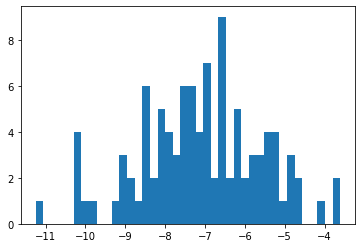

In [ ]:
plt.hist(relative, bins=40)

Similar shape as Shannon entropy. Nice spread too. Now checking the correlation

### Further vizualisations

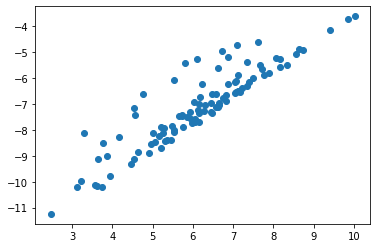

In [ ]:
plt.scatter(shannon, relative)

(0.6503166981530246, 2.4390516311126865e-13)


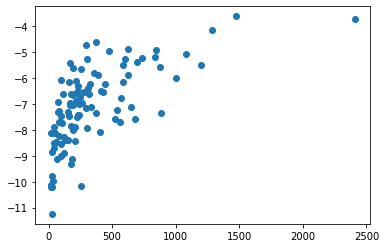

In [ ]:
plt.scatter(total_playcount, relative)
print(pearsonr(total_playcount, relative))

(0.6953520529205681, 9.961851248773004e-16)


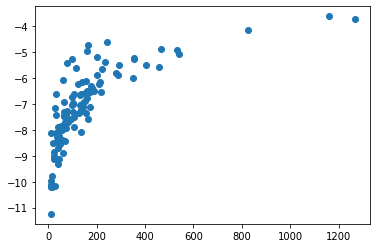

In [ ]:
plt.scatter(distinct_songs, relative)
print(pearsonr(distinct_songs, relative))

(0.7284076602276596, 8.824766787315398e-18)


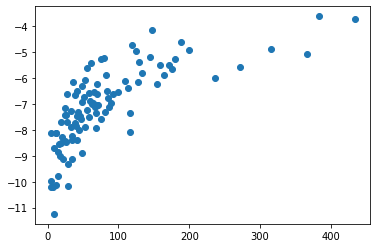

In [ ]:
plt.scatter(distinct_artists, relative)
print(pearsonr(distinct_artists, relative))

(0.5029489869189632, 9.673880863338638e-08)


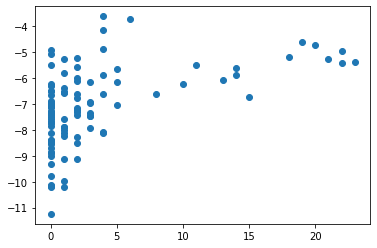

In [ ]:
plt.scatter(pop_score, relative)
print(pearsonr(pop_score, relative))

Strong positive correlation as expected. There is some tendency for the users to have relativelly higher KL divergence score than the Shannon entropy score meaning that some users might be seen more mainstream generalist than they are seen generalist

## Gini-index


In [58]:
# Gini function
def gini(p):
    c = []
    for i in p:
        b = i**2
        c.append(b)
    d = 1 - sum(c)    
    return d

In [59]:
# getting gini index for each user independently
gini_index = []
for i in users:
  b = toy_triplets["Count"][toy_triplets["UserId"]==i]/(np.sum(toy_triplets["Count"][toy_triplets["UserId"]==i]))
  a = gini(b)
  gini_index.append(a)

(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,
          0.,   0.,   0.,   1.,   0.,   0.,   1.,   0.,   0.,   2.,   1.,
          0.,   3.,   1.,   3.,   5.,   4.,   6.,  10.,   9.,   9.,  28.,
         29.,  80., 125., 169., 161., 203., 148.]),
 array([0.13834529, 0.15979911, 0.18125293, 0.20270675, 0.22416057,
        0.24561439, 0.26706821, 0.28852202, 0.30997584, 0.33142966,
        0.35288348, 0.3743373 , 0.39579112, 0.41724494, 0.43869876,
        0.46015257, 0.48160639, 0.50306021, 0.52451403, 0.54596785,
        0.56742167, 0.58887549, 0.6103293 , 0.63178312, 0.65323694,
        0.67469076, 0.69614458, 0.7175984 , 0.73905222, 0.76050604,
        0.78195985, 0.80341367, 0.82486749, 0.84632131, 0.86777513,
        0.88922895, 0.91068277, 0.93213659, 0.9535904 , 0.97504422,
        0.99649804]),
 <a list of 40 Patch objects>)

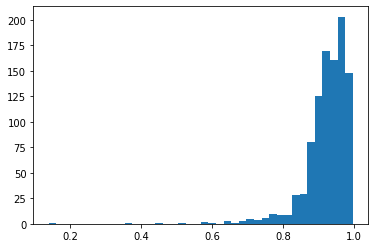

In [60]:
plt.hist(gini_index, bins = 40)

Most of the values are large - inbetween 0.9 and 1 indicating that according to Gini index, most of the users are rather generalist - the probability of two random draws with replacement to be different is large. The data spread is limited and that is an issue. I suppose this is due to the very small probabilities $p_{ij}$.

### Further vizualisations

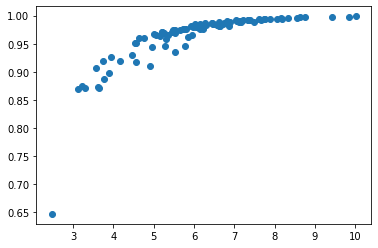

In [ ]:
plt.scatter(shannon, gini_index)

In [ ]:
pearsonr(shannon, gini_index)

(0.7569033232483608, 8.294982060204223e-20)

Correlation between Gini index and Shannon entropy is lower thant that between the latter and the relative entropy. Also, we see a concave quadratic relationship between the Shannon entropy and Gini index. It is still positive.

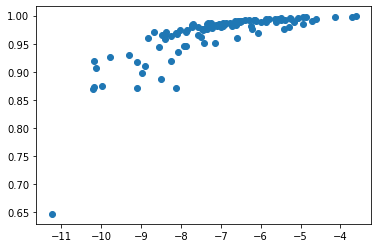

In [ ]:
plt.scatter(relative, gini_index)

Relationship between the Gini index and the KL divergence is very similar to the one between Gini and Shannon entropy with more noise added due to the different benchmark measurement of the KL divergence.

(0.3623331572356941, 0.00021182079939306535)


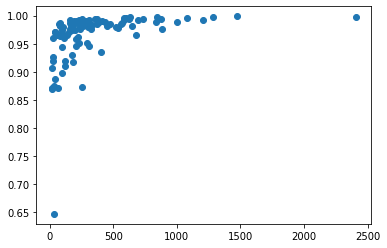

In [ ]:
plt.scatter(total_playcount, gini_index)
print(pearsonr(total_playcount, gini_index))

(0.36844405429677524, 0.00016213438786873586)


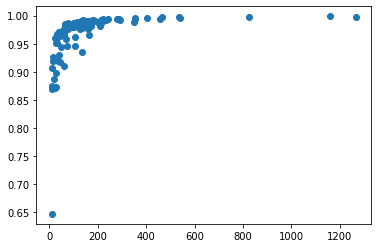

In [ ]:
plt.scatter(distinct_songs, gini_index)
print(pearsonr(distinct_songs, gini_index))

(0.4007877269958482, 3.5947305173808e-05)


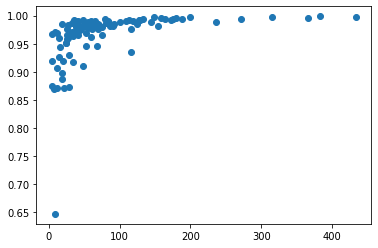

In [ ]:
plt.scatter(distinct_artists, gini_index)
print(pearsonr(distinct_artists, gini_index))

(0.1890081970222846, 0.05965539491488829)


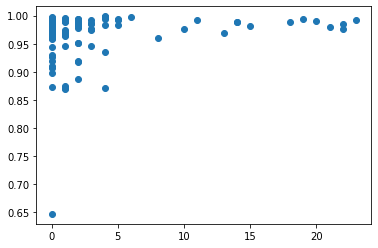

In [ ]:
plt.scatter(pop_score, gini_index)
print(pearsonr(pop_score, gini_index))

## Hill number


In [53]:
# Hill number function
def hill(p,q):
    c =[]
    for i in p:
        b = i**q
        c.append(b)
    d = sum(c)**(1/(1-q))   
    return d

In [61]:
# implementation for each user and then aggregating in list "hill_no"
hill_no = []
for i in users:
  b = toy_triplets["Count"][toy_triplets["UserId"]==i]/(np.sum(toy_triplets["Count"][toy_triplets["UserId"]==i]))
  a = hill(b,2)
  hill_no.append(a)

(array([149., 360., 164.,  92.,  66.,  40.,  34.,  20.,  19.,   7.,  13.,
          6.,   6.,   2.,   2.,   1.,   0.,   2.,   2.,   1.,   2.,   2.,
          1.,   0.,   0.,   1.,   2.,   0.,   1.,   0.,   0.,   0.,   0.,
          2.,   0.,   1.,   0.,   0.,   0.,   2.]),
 array([  1.16055769,   8.27040661,  15.38025553,  22.49010445,
         29.59995337,  36.70980229,  43.81965121,  50.92950013,
         58.03934905,  65.14919797,  72.25904689,  79.36889581,
         86.47874473,  93.58859365, 100.69844257, 107.80829149,
        114.91814041, 122.02798933, 129.13783825, 136.24768717,
        143.35753609, 150.46738501, 157.57723393, 164.68708285,
        171.79693177, 178.90678069, 186.01662961, 193.12647853,
        200.23632744, 207.34617636, 214.45602528, 221.5658742 ,
        228.67572312, 235.78557204, 242.89542096, 250.00526988,
        257.1151188 , 264.22496772, 271.33481664, 278.44466556,
        285.55451448]),
 <a list of 40 Patch objects>)

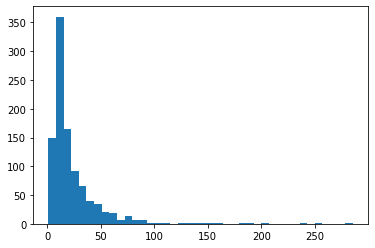

In [62]:
plt.hist(hill_no, bins = 40)

There is somewhat more spread than with the Gini index with most of the Hill values ranging from 2 to just bellow 200 categories indicating that it would be easier to define a threashold for the specialist/ generialist labeling.

### Further vizualisations

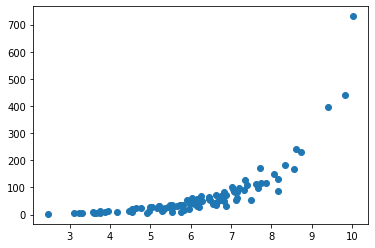

In [ ]:
plt.scatter(shannon, hill_no)

In [ ]:
pearsonr(shannon, hill_no)

(0.7286355815928001, 8.521424069815568e-18)

Now we have positive quadratic convex relationship. The data spread is clearly better than with Gini index. The correlation with the Shannon entropy is, however smaller. It seems that users with large entropy values tend to require fewer equifrequent songs that one would expect under the linear relationship case. 

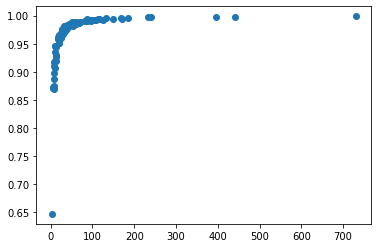

In [ ]:
plt.scatter(hill_no, gini_index)

In [ ]:
pearsonr(hill_no, gini_index)

(0.354661385886188, 0.0002940824874292938)

Extremelly low correlation between Hill number and Gini index and a rather non-sensial scatter plots indicates that these two measures are rather different and capture different aspect of the data.

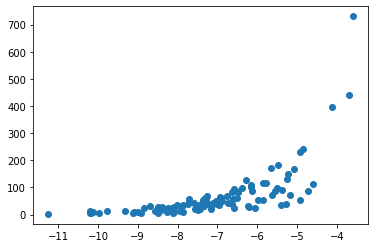

In [ ]:
plt.scatter(relative, hill_no)

The relationship between the Hill number and KL divergence is rather similar to the one between the former and the Shannon entropy, yet with more noise potentialy arising due to the KL divergence measuring similarity to the mainstream generalist as opposed to the overall generalist

(0.7296702659829094, 7.267025789410607e-18)


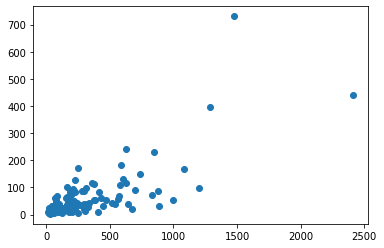

In [ ]:
plt.scatter(total_playcount, hill_no)
print(pearsonr(total_playcount, hill_no))

(0.9243580114756229, 8.472933454673683e-43)


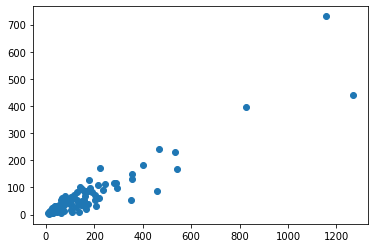

In [ ]:
plt.scatter(distinct_songs, hill_no)
print(pearsonr(distinct_songs, hill_no))

(0.7563008853508721, 9.215584375707458e-20)


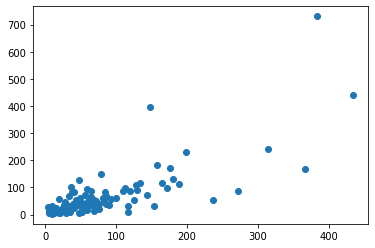

In [ ]:
plt.scatter(distinct_artists, hill_no)
print(pearsonr(distinct_artists, hill_no))

(0.08073294240675358, 0.42458975538770616)


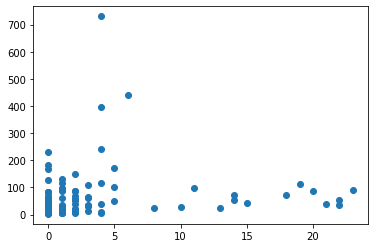

In [ ]:
plt.scatter(pop_score, hill_no)
print(pearsonr(pop_score, hill_no))

# Entropy concordance

In [ ]:
toy_with_pop = pd.merge(left = toy_artist_merge, right = Q_id, right_on = "SongId", left_on = "SongId")

In [ ]:
a = np.array(shannon) - (np.array(relative))

In [ ]:
import scipy.stats as stats

tau, p_value = stats.kendalltau(shannon, relative)

In [ ]:
tau

0.7563636363636365

In [ ]:
shannon_r = stats.rankdata(shannon, method="min")
relative_r = stats.rankdata(relative, method="min")

In [ ]:
tau, p_value = stats.kendalltau(shannon_r, relative_r)

In [ ]:
tau

0.7563636363636365

In [ ]:
a = shannon_r-relative_r

(array([ 1.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,
         0.,  1.,  0.,  3.,  2.,  0.,  0.,  0.,  1.,  1.,  1.,  0.,  2.,
         7.,  1.,  9.,  8.,  6.,  9.,  6.,  4.,  4., 14.,  8.,  3.,  3.,
         1.]),
 array([-47. , -45.4, -43.8, -42.2, -40.6, -39. , -37.4, -35.8, -34.2,
        -32.6, -31. , -29.4, -27.8, -26.2, -24.6, -23. , -21.4, -19.8,
        -18.2, -16.6, -15. , -13.4, -11.8, -10.2,  -8.6,  -7. ,  -5.4,
         -3.8,  -2.2,  -0.6,   1. ,   2.6,   4.2,   5.8,   7.4,   9. ,
         10.6,  12.2,  13.8,  15.4,  17. ]),
 <a list of 40 Patch objects>)

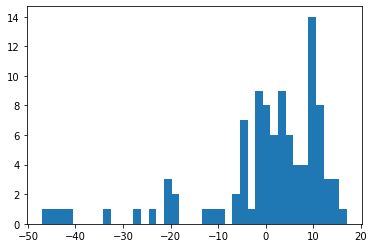

In [ ]:
plt.hist(a, bins = 40)

{'boxes': [<matplotlib.lines.Line2D at 0x7fb374251f60>],
 'caps': [<matplotlib.lines.Line2D at 0x7fb3741d7978>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fb3741f1668>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7fb3741f11d0>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7fb3741d70f0>,
  <matplotlib.lines.Line2D at 0x7fb3741d74e0>]}

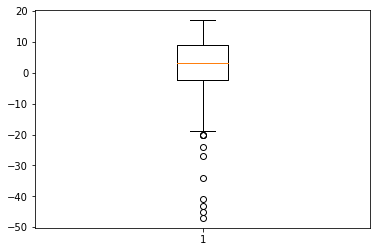

In [ ]:
plt.boxplot(a)

In [ ]:
pd.DataFrame(a).describe()

,0
count,100.000000
mean,0.000000
std,13.179415
min,-47.000000
25%,-2.250000
50%,3.000000
75%,9.000000
max,17.000000


,0
count,100.000000
mean,6.140856
std,1.490102
min,2.468433
25%,5.252517
50%,6.155510
75%,7.083454
max,10.020287


In [ ]:
# check where values are more than 10
np.where(a == 17)

(array([28]),)

In [ ]:
toy_with_pop[toy_with_pop["UserId"] == users[28]]

,UserId,SongId,Count,TrackId,Artist,Song_name,Freq_q
836,ac006af6edb9b4b5345b8c268c3d205bc1b15001,SOQTPLM12B0B809575,1,TRAJNLN128F427D137,The Black Keys,Strange Times,3
983,ac006af6edb9b4b5345b8c268c3d205bc1b15001,SOTEPSZ12AB018C99D,1,TRKSEEY12903CCD312,The Black Keys,Ten Cent Pistol,3
3320,ac006af6edb9b4b5345b8c268c3d205bc1b15001,SOXGXKY12A8C13A405,2,TRRJFXX128F427A71F,The Black Keys,Remember When (Side A),2
3532,ac006af6edb9b4b5345b8c268c3d205bc1b15001,SOITRTA12A6D4F8261,7,TRDRTNQ128F93313A3,Metallica,Ride The Lightning,3
4718,ac006af6edb9b4b5345b8c268c3d205bc1b15001,SOMRTUH12AB0185650,1,TRSVTRT12903CB450E,The Black Keys,The Lengths,2
...,...,...,...,...,...,...,...
7408,ac006af6edb9b4b5345b8c268c3d205bc1b15001,SOYKZMF12A8C132C30,1,TRIFTWF128F426ADD7,John Denver,Eagles And Horses,1
7409,ac006af6edb9b4b5345b8c268c3d205bc1b15001,SOYXSUQ12A8C13BC13,1,TRGOZHU128F427F9A5,Mariana Aydar,Maior É Deus,1
7410,ac006af6edb9b4b5345b8c268c3d205bc1b15001,SOZKXKH12A8C131FFB,1,TRIMNTB128F424E2C2,Ultraje A Rigor,Nós Vamos Invadir Sua Praia,1
7411,ac006af6edb9b4b5345b8c268c3d205bc1b15001,SOZODMP12AB018061F,12,TROQOJH128F92EFDD4,Major Lazer / Mr. Lex / Santigold,Hold The Line,2


In [ ]:
print(shannon_r[28], relative_r[28], 
      shannon[28], relative[28])

59 42 6.481286056696259 -7.356461018722857


In [ ]:
print(total_playcount[28], distinct_songs[28], distinct_artists[28], pop_score[28])

373 129 68 0


,0
count,100.000000
mean,343.080000
std,364.844195
min,16.000000
25%,110.750000
50%,225.000000
75%,436.000000
max,2409.000000


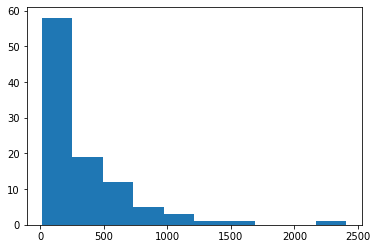

In [ ]:
plt.hist(total_playcount)
pd.DataFrame(total_playcount).describe()

,0
count,100.000000
mean,160.550000
std,201.392846
min,10.000000
25%,53.250000
50%,104.500000
75%,173.750000
max,1267.000000


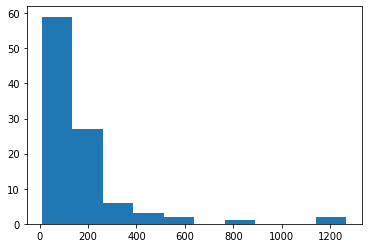

In [ ]:
plt.hist(distinct_songs)
pd.DataFrame(distinct_songs).describe()

,0
count,100.000000
mean,81.100000
std,81.199654
min,4.000000
25%,28.750000
50%,57.500000
75%,102.250000
max,434.000000


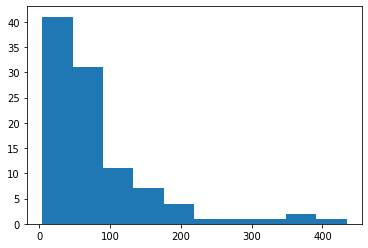

In [ ]:
plt.hist(distinct_artists)
pd.DataFrame(distinct_artists).describe()

,0
count,100.000000
mean,3.410000
std,5.759656
min,0.000000
25%,0.000000
50%,1.000000
75%,3.250000
max,23.000000


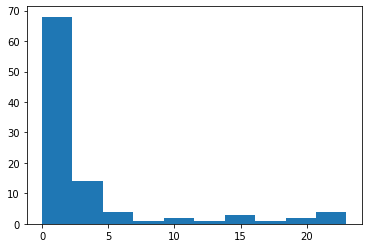

In [ ]:
plt.hist(pop_score)
pd.DataFrame(pop_score).describe()

In [ ]:
# check where values are more than 10
np.where(a == -47)

(array([57]),)

In [ ]:
print(shannon_r[57], relative_r[57], 
      shannon[57], relative[57])

39 86 5.801164626079563 -5.404896860761347


In [ ]:
print(total_playcount[57], distinct_songs[57], distinct_artists[57], pop_score[57])

167 76 61 22


So Shannon vs KL divergence is pure popularity difference.

## Shannon - Hill number

In [ ]:
hill_no_r = stats.rankdata(hill_no, method = "min")

In [ ]:
tau, p_value = stats.kendalltau(shannon_r, hill_no_r)

In [ ]:
print(tau, p_value)

0.8630303030303031 4.4335715544411205e-37


In [ ]:
diff_b = np.array(shannon_r)-np.array(hill_no_r) 

(array([ 3.,  7., 12., 28., 23., 13.,  4.,  4.,  3.,  3.]),
 array([-15. , -11.4,  -7.8,  -4.2,  -0.6,   3. ,   6.6,  10.2,  13.8,
         17.4,  21. ]),
 <a list of 10 Patch objects>)

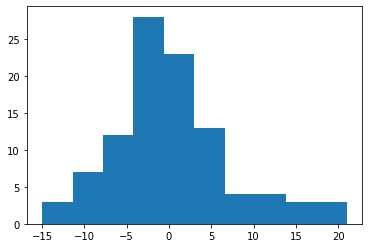

In [ ]:
plt.hist(diff_b)

In [ ]:
pd.DataFrame(diff_b).describe()

,0
count,100.000000
mean,0.000000
std,6.928203
min,-15.000000
25%,-4.000000
50%,-0.500000
75%,3.000000
max,21.000000


In [ ]:
print(np.where(diff_b == 21), np.where(diff_b==-15))

(array([55]),) (array([32]),)


In [ ]:
print(shannon_r[21], hill_no_r[21], 
      shannon[21], hill_no[21])

64 41 6.641596465690961 33.890953891150104


In [ ]:
print(total_playcount[55], distinct_songs[55], distinct_artists[55], pop_score[55])

448 209 154 0


In [ ]:
toy_artist_merge[toy_artist_merge["UserId"]==users[55]]

,UserId,SongId,Count,TrackId,Artist,Song_name
1397,9d633fa5e6c1e6c4304d3394a1c1802d04e9d5e2,SOTUYFC12A8C13AE26,1,TRTAEKL128F92F8DB8,Noosa Head Feat. Marshall Jefferson,Mushrooms
3155,9d633fa5e6c1e6c4304d3394a1c1802d04e9d5e2,SOSJDQJ12A8C13D4A9,1,TRABOVH128F427D3B4,Chromeo,Fancy Footwork
3299,9d633fa5e6c1e6c4304d3394a1c1802d04e9d5e2,SOWRTJD12A8C132704,1,TRXIOUQ128F4269099,Aerosmith,Dream On
3341,9d633fa5e6c1e6c4304d3394a1c1802d04e9d5e2,SOZVCRW12A67ADA0B7,1,TRNTALF128EF343800,The Killers,When You Were Young
3460,9d633fa5e6c1e6c4304d3394a1c1802d04e9d5e2,SOFFQBG12A6D4F9793,2,TREIHZT128F146E229,Juanes,La Camisa Negra
...,...,...,...,...,...,...
10973,9d633fa5e6c1e6c4304d3394a1c1802d04e9d5e2,SOZJEAW12A58A761DB,5,TRRAXZJ128F92F56A8,Wilson Pickett,Land Of 1000 Dances
10974,9d633fa5e6c1e6c4304d3394a1c1802d04e9d5e2,SOZNBUK12A8C1383E3,1,TRMSIRD128F427EEFD,Sufjan Stevens,Sleeping Bear_ Sault Saint Marie
10975,9d633fa5e6c1e6c4304d3394a1c1802d04e9d5e2,SOZNMYQ12A6D4F837E,2,TRNGMZZ128F1469CFE,Wagon Christ,Piano Playa Hata
10976,9d633fa5e6c1e6c4304d3394a1c1802d04e9d5e2,SOZSNXB12A6310E141,1,TRQACSU128F1460103,Bentley Rhythm Ace,Jim'll Twist It


(array([150.,  25.,  10.,   6.,   6.,   2.,   4.,   1.,   0.,   0.,   1.,
          0.,   0.,   0.,   2.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,
          0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([ 1.   ,  1.925,  2.85 ,  3.775,  4.7  ,  5.625,  6.55 ,  7.475,
         8.4  ,  9.325, 10.25 , 11.175, 12.1  , 13.025, 13.95 , 14.875,
        15.8  , 16.725, 17.65 , 18.575, 19.5  , 20.425, 21.35 , 22.275,
        23.2  , 24.125, 25.05 , 25.975, 26.9  , 27.825, 28.75 , 29.675,
        30.6  , 31.525, 32.45 , 33.375, 34.3  , 35.225, 36.15 , 37.075,
        38.   ]),
 <a list of 40 Patch objects>)

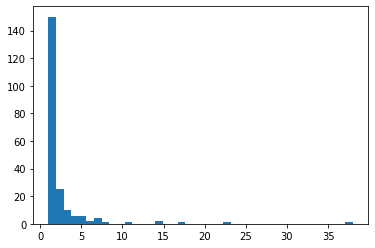

In [ ]:
plt.hist(toy_artist_merge["Count"][toy_artist_merge["UserId"]==users[55]], bins = 40)

Ranking difference among those who have large count songs.  This is because frequent songs contribute only very small number to the Hill's number. This means that user 55, who according his behaviour should be listened as a strong generalist due to her playcount, number of artist and song stemming from classic rock to electornic and classical music is labelled as specialist because he has a few songs with relativelly high counts. Maybe we should do Hill q = 2? Hill CAN put more emphasis on more abundand categories. This might be useful. When changed to q = 2, the disconcordance decreased (Kendel's Tau rose to 0.86), yet the two most extreme values remained the same - 55 and 32.


## Shannon - Gini 

In [ ]:
gini_r = stats.rankdata(gini_index, method="min")
tau, p_val = stats.kendalltau(hill_no_r, gini_r)
print(tau, p_value)

1.0 4.4335715544411205e-37


,0
count,100.000000
mean,0.000000
std,6.928203
min,-15.000000
25%,-4.000000
50%,-0.500000
75%,3.000000
max,21.000000


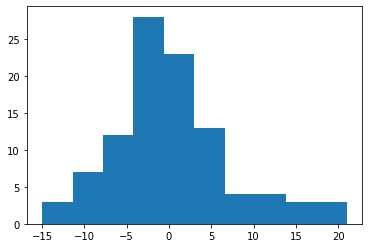

In [ ]:
diff_c = np.array(shannon_r) - np.array(gini_r)
plt.hist(diff_c)
pd.DataFrame(diff_c).describe()

In [ ]:
print(np.where(diff_c==21), np.where(diff_c==-15))
# same as Hill vs Shannon

(array([55]),) (array([32]),)


In [ ]:
print(shannon_r[55], gini_r[55], 
      shannon[55], gini_index[55])

70 49 6.873332756614353 0.9816047512755102


# Full data trial

In [ ]:
users = artist_merge["UserId"].unique().tolist()

# calculating the Shannon entropy for each user separatelly and stacking
# everything into the list "shannon"
shannon = []
for i in users:
  b = artist_merge["Count"][artist_merge["UserId"]==i]/(np.sum(artist_merge["Count"][artist_merge["UserId"]==i]))
  a = entropy_me(b)
  shannon.append(a)

KeyboardInterrupt: ignored